# Data science for business project
This project is developed by 
- Drago Emanuele
- Lambrughi Achille

# Index


- [Introduction](#Introduction)<a href='#Introduction'></a><br>
- [Resources](#res)<a href='res'></a><br>
- [Configuration](#config)<a href='config'></a><br>
- [Library](#lib)<a href='lib'></a><br>
- [Function defined](#my_fun)<a href='my_fun'></a><br>

[**Dataset analysis**](#cap1)<a href='cap1'></a><br>
- [Dataset Import](#dt_import)<a href='dt_import'></a><br>
- [Outlier detection](#dec_outlier)<a href='dec_outlier'></a><br>
    - [DATA column](#data_cl)<a href='data_cl'></a><br>
    - [SETTOREECONOMICODETTAGLIO column](#set_ec_cl)<a href='linear_regression'></a><br>
    - [MODALITALAVORO column](#mod_work_cl)<a href='mod_work_cl'></a><br>
    
[**Building machine learning models**](#ml_model)<a href='ml_model'></a><br>
- [Feature encoding](#feature_encoding)<a href='feature_encoding'></a><br>
    - [Direct Encoding](#simp_encoding)<a href='simp_encoding'></a><br>
    - [Our Encoding](#elab_encoding)<a href='elab_encoding'></a><br>
- [Models Traning](#models_trainig)<a href='models_trainig'></a><br>


<a id='Introduction'></a>
## Introduction
The aim of this project is to illustrates various fases of a data science project. In the first fase we will import and analyze a dataset, then based on the analysis result we clean up the data removing outlier and null value.
Once the data is ready we will buid a machine learning model able to respond to some question regarding the data.

<a id='res'></a>
## Resources
The datasets considered are available at the following link:
- https://www.dati.lombardia.it/Attivit-Produttive/Rapporti-di-lavoro-attivati/qbau-cyuc
- https://esploradati.censimentopopolazione.istat.it/databrowser/#/it/censtest/ITC4

other resources:
https://www.google.it/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiamPWll5T4AhUSG-wKHYxBBooQFnoECAcQAQ&url=https%3A%2F%2Fwww.istat.it%2Fstorage%2Fcodici-unita-amministrative%2FElenco-comuni-italiani.xls&usg=AOvVaw1grUzCb-YznlY1XTyzCUJE

in this file the column *Denominazione dell'Unità territoriale sovracomunale 
(valida a fini statistici)* has been renamed in *Provincia*



<a id='config'></a>
### Configuration
For this project will be used the module xgboost so for a correct compiling of the code is necessary to install it.

<a id='lib'></a>
### Library used
The following cell contain the main library used for the project, some library are imported right after used

In [294]:
import numpy as np
import pandas as pd
import matplotlib as mpl, matplotlib.pyplot as plt
from pathlib import PurePath
from datetime import datetime, timedelta
import seaborn as sns
mpl.rcParams['figure.dpi'] = 150

<a id='my_fun'></a>
### Definig some function
Before proceding with the dataset we define the following function:
- `series_to_set`: this function take as input a column and a dataframe and returs a set containing the column value
- `mapping`: this function takes as input a series and a mapping dictionary,returns the series mapped to the dictionary

In [295]:
def series_to_set(column, source_df):
    SET = set()
    for elem in source_df[column]:
        SET.add(elem)
    return SET

def mapping(series, mapp): 
    series = series.apply(lambda x: mapp.get(x) if mapp.get(x) != None else x)
    return series

<a id='cap1'></a>
# Dataset analysis
In this section will be analyzed the content of the dataset. The choosen datase contain the new work contract activated in Lombardy. The dataset contains the following column:
- DATA: date of the contract
- GENERE: sex of the person
- ETA: age of the person
- SETTOREECONOMICODETTAGLIO: category of work
- TITOLOSTUDIO: level of education of the person
- CONTRATTO: type of contract
- MODALITALAVORO: work mode
- PROVINCIAIMPRESA: province of the place of work
- ITALIANO: nationality of the person


<a id='dt_import'></a>
### Dataset import
 Here we import the dataset, parse the field `DATA` to datetime and take a first look at the column and their type.

In [296]:
source_df = pd.read_csv(PurePath('dataset', 'Rapporti_di_lavoro_attivati.csv'),parse_dates=['DATA'])

In [297]:
rap_lavoro_attivati = source_df.copy()

In [298]:
print([rap_lavoro_attivati.info()])
rap_lavoro_attivati.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9579794 entries, 0 to 9579793
Data columns (total 9 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   DATA                       datetime64[ns]
 1   GENERE                     object        
 2   ETA                        int64         
 3   SETTOREECONOMICODETTAGLIO  object        
 4   TITOLOSTUDIO               object        
 5   CONTRATTO                  object        
 6   MODALITALAVORO             object        
 7   PROVINCIAIMPRESA           object        
 8   ITALIANO                   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 657.8+ MB
[None]


,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,2020-09-05,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA
1,2019-12-07,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
2,2013-05-06,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,2010-12-03,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA
4,2021-06-04,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA
5,2021-06-08,M,16,"Costruzione di strade, autostrade e piste aero...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018-04-03,F,56,Confezioni di abbigliamento sportivo o di altr...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
7,2011-06-10,M,20,Demolizione,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE,TEMPO PIENO,BERGAMO,ITALIA
8,2013-03-07,M,49,Demolizione,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
9,2014-03-06,M,29,Ristorazione con somministrazione,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ERITREA


### Changing data type
As we can see almost all columns of the dataset have type object and contains strings, this  means that the machine learning model will be fed with catagorical data or a numerical rapresentation of it. Before proceding with the analysis we change the type from object to string.

In [299]:
rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']]=rap_lavoro_attivati[['GENERE','SETTOREECONOMICODETTAGLIO','TITOLOSTUDIO','CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','ITALIANO']].astype('string')

### Searching wrong and null data
Now we will look inside the data checking null or possibly wrong value, after those data will be corrected or deleted.
First off we will find out how many null value there are in each column

In [300]:
print([rap_lavoro_attivati.isnull().sum()])

[DATA                              0
GENERE                            0
ETA                               0
SETTOREECONOMICODETTAGLIO      2888
TITOLOSTUDIO                    580
CONTRATTO                         0
MODALITALAVORO               440779
PROVINCIAIMPRESA                  0
ITALIANO                          0
dtype: int64]


From this first look is possible to see that a big part of value is missing from the column `MODALITALAVORO` of the dataset `Rapporti_di_lavoro_attivati` these value needs to be replaced while the other could be simply deleted because they represent a small part of the dataset.

But before proceding now will be checked the actual value of some columnn to see if there are some non plausible data.
Starting from the column `DATA`

<a id='dec_outlier'></a>
## Identifying outliers

<a id='data_cl'></a>
### column DATA

# Print some graph (like box plot)

se possibile far vedere che ci sono pochi valori prima del 2008 così da poter eliminare direttamente i valori prima del 2008 e dopo il 2022

In [302]:
rap_lavoro_attivati['DATA'] = rap_lavoro_attivati['DATA'].apply(lambda x: x.year)

In [303]:
rap_lavoro_attivati = rap_lavoro_attivati[rap_lavoro_attivati['DATA'] < 2022]

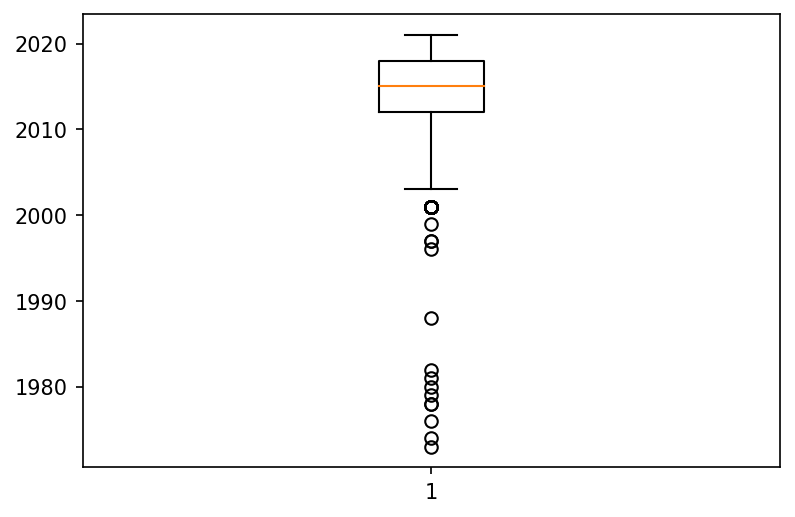

In [304]:
fig, ax = plt.subplots()
ax.boxplot(rap_lavoro_attivati['DATA'])
plt.show()

In [305]:
rap_lavoro_attivati['DATA'].head()

0    2020
1    2019
2    2013
3    2010
4    2021
Name: DATA, dtype: int64


## Working on column `DATA`
In this section we will analyze in more detail the column `DATA` and adjust the data accordingly.
The first step is to group the column by year and count how many contract are activated per year

In [309]:
rap_lavoro_attivati = rap_lavoro_attivati[(rap_lavoro_attivati.DATA >= 2018) & (rap_lavoro_attivati.DATA < 2020)]
print(rap_lavoro_attivati.groupby(['DATA']).count())

      GENERE     ETA  SETTOREECONOMICODETTAGLIO  TITOLOSTUDIO  CONTRATTO  \
DATA                                                                       
2018  899082  899082                     898803        899082     899082   
2019  874079  874079                     873769        874079     874079   

      MODALITALAVORO  PROVINCIAIMPRESA  ITALIANO  
DATA                                              
2018          899082            899082    899082  
2019          874079            874079    874079  


as is possible to see meany of the value have date between 2009 and 2022, so to have a more significant set of data we will remove all the row with date previous to 2009

In [310]:
rap_lavoro_attivati = rap_lavoro_attivati[(rap_lavoro_attivati["DATA"] >= 2009)]
attivatiTemp = rap_lavoro_attivati[(rap_lavoro_attivati["DATA"] >= 2009)]

In [312]:
print(attivatiTemp.groupby(['DATA']).count())

      GENERE     ETA  SETTOREECONOMICODETTAGLIO  TITOLOSTUDIO  CONTRATTO  \
DATA                                                                       
2018  899082  899082                     898803        899082     899082   
2019  874079  874079                     873769        874079     874079   

      MODALITALAVORO  PROVINCIAIMPRESA  ITALIANO  
DATA                                              
2018          899082            899082    899082  
2019          874079            874079    874079  


With this we can see how many contract have been activated in the last few years in the Lombardy region.

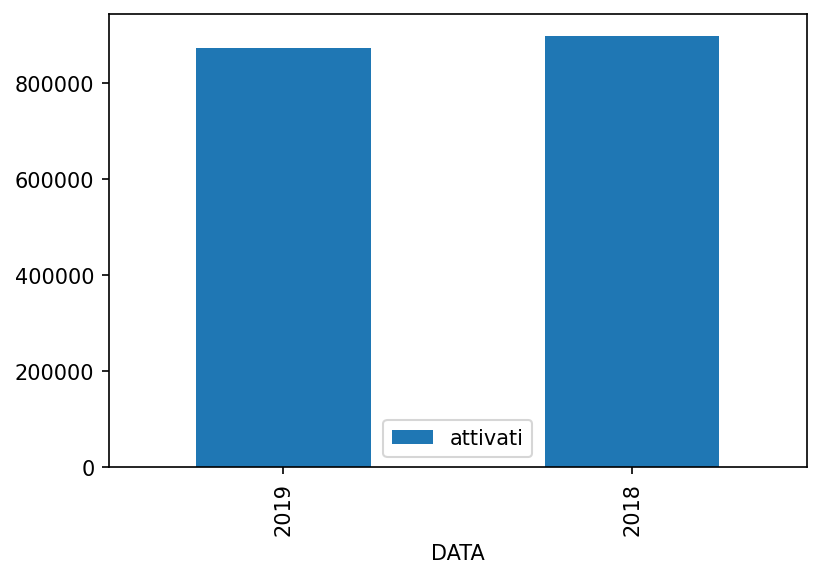

In [314]:
attivatiTemp.groupby(pd.Grouper(key='DATA'))['DATA'].count().plot(label="attivati", kind='bar')

plt.legend()
plt.show()

the next graph show the percentrage difference between male and female 

(-1.1120274017317229,
 1.1262977938586096,
 -1.11073016988544,
 1.1005109604707353)

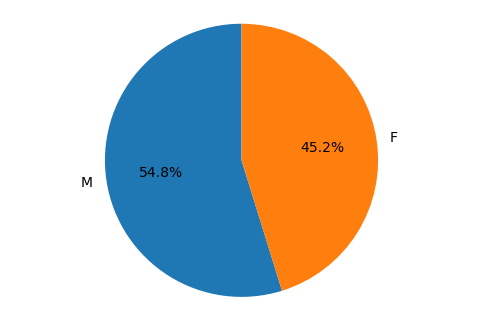

In [315]:
m_to_f_rationA = rap_lavoro_attivati.GENERE.value_counts()

xaxisA = m_to_f_rationA.index
valueA = m_to_f_rationA.values

fig1, axis = plt.subplots(1)
fig1.dpi = 100

#Attivati male to female Graph
axis.pie(valueA, labels=xaxisA, autopct='%1.1f%%', startangle=90)
axis.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


from these graphs we can say that probably there are more male than female in the popoulation

In [316]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count    1.773161e+06
mean     2.018493e+03
std      4.999504e-01
min      2.018000e+03
25%      2.018000e+03
50%      2.018000e+03
75%      2.019000e+03
max      2.019000e+03
Name: DATA, dtype: float64

from this we can see that there is at least one date impossible so we restrain the data to only feasible one

In [318]:
rap_lavoro_attivati['DATA'].describe(datetime_is_numeric=True)

count    1.773161e+06
mean     2.018493e+03
std      4.999504e-01
min      2.018000e+03
25%      2.018000e+03
50%      2.018000e+03
75%      2.019000e+03
max      2.019000e+03
Name: DATA, dtype: float64

In [319]:
rap_lavoro_attivati['DATA'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 1          2019
6          2018
12         2019
23         2018
28         2019
           ... 
9579758    2018
9579764    2018
9579777    2018
9579779    2018
9579788    2019
Name: DATA, Length: 1773161, dtype: int64>

In [320]:
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
1,2019,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018,F,56,Confezioni di abbigliamento sportivo o di altr...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
12,2019,F,34,Istruzione di grado preparatorio: scuole dell'...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
23,2018,M,54,Allevamento di bovini e bufalini da carne,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO
28,2019,F,45,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA


<a id='set_ec_cl'></a>
### column SETTOREECONOMICODETTAGLIO

In [321]:
settore_economico = series_to_set('SETTOREECONOMICODETTAGLIO', rap_lavoro_attivati)
len(settore_economico)

1183

# Grafico outlier e occorrenze per valore
far vedere nel grafico che la maggior parte dei valori appartengono alle prime categorie e quindi si terranno solo quelle

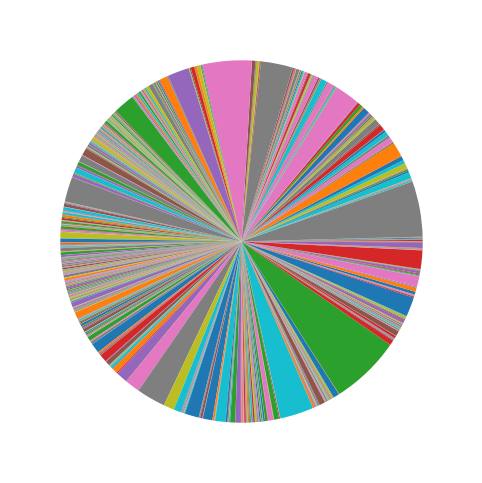

In [322]:
fig, axis = plt.subplots()

axis.pie(rap_lavoro_attivati.groupby(['SETTOREECONOMICODETTAGLIO']).count()['GENERE'])

plt.show()

In [323]:
sett_eco_codes = pd.read_excel(PurePath('dataset', 'CodiceAteco.xlsx'))
sett_eco_codes.head()

,Lettera,Codice Ateco 2007,Descrizione
0,A,A,"AGRICOLTURA, SILVICOLTURA E PESCA"
1,A,01,COLTIVAZIONI AGRICOLE E PRODUZIONE DI PRODOTTI...
2,A,01.1,COLTIVAZIONE DI COLTURE AGRICOLE NON PERMANENTI
3,A,01.11,"Coltivazione di cereali (escluso il riso), leg..."
4,A,01.11.1,Coltivazione di cereali (escluso il riso)


In [324]:
sett_eco_codes['Descrizione'] = sett_eco_codes['Descrizione'].str.lower()
sett_eco_codes = sett_eco_codes[['Lettera', 'Descrizione']]
ateco = sett_eco_codes.set_index('Descrizione').to_dict().get('Lettera')
ateco

{'agricoltura, silvicoltura e pesca': 'A',
 'coltivazioni agricole e produzione di prodotti animali, caccia e servizi connessi': 'A',
 'coltivazione di colture agricole non permanenti': 'A',
 'coltivazione di cereali (escluso il riso), legumi da granella e semi oleosi': 'A',
 'coltivazione di cereali (escluso il riso)': 'A',
 'coltivazione di semi oleosi': 'A',
 'coltivazione di legumi da granella': 'A',
 'coltivazioni miste di cereali, legumi da granella e semi oleosi': 'A',
 'coltivazione di riso': 'A',
 'coltivazione di ortaggi e meloni, radici e tuberi': 'A',
 'coltivazione di ortaggi (inclusi i meloni) in foglia, a fusto, a frutto, in radici, bulbi e tuberi in piena aria (escluse barbabietola da zucchero e patate)': 'A',
 'coltivazione di ortaggi (inclusi i meloni) in foglia, a fusto, a frutto, in radici, bulbi e tuberi in colture protette (escluse barbabietola da zucchero e patate)': 'A',
 nan: 'A',
 'coltivazione di ortaggi (inclusi i meloni) in foglia, a fusto, a frutto, in rad

In [325]:
rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"] = rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"].str.lower()
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
1,2019,M,43,"gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018,F,56,confezioni di abbigliamento sportivo o di altr...,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
12,2019,F,34,istruzione di grado preparatorio: scuole dell'...,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
23,2018,M,54,allevamento di bovini e bufalini da carne,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO
28,2019,F,45,attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA


In [326]:
rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"] = rap_lavoro_attivati["SETTOREECONOMICODETTAGLIO"].map(ateco)
rap_lavoro_attivati.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
1,2019,M,43,NaN,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
6,2018,F,56,C,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
12,2019,F,34,P,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
23,2018,M,54,A,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO
28,2019,F,45,T,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA


In [327]:
rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].isna().sum()

35237

In [328]:
rap_lavoro_attivati = rap_lavoro_attivati[rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].notna()]

In [329]:
rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].isna().sum()

0

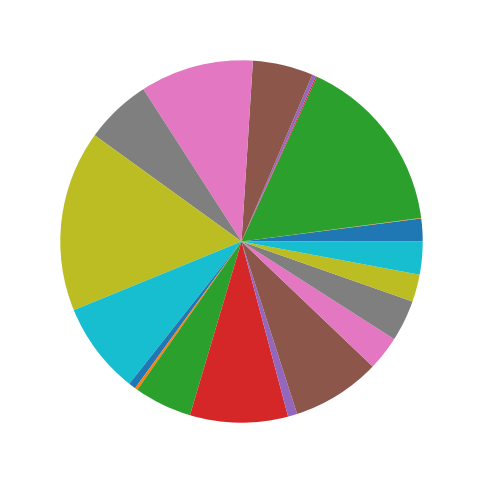

In [330]:
fig, axis = plt.subplots()

axis.pie(rap_lavoro_attivati.groupby(['SETTOREECONOMICODETTAGLIO']).count()['GENERE'])

plt.show()

Since the `SETTOREECONOMICODETTAGLIO` column has more than a thousand unique values belonging to it, it cannot be easily exploited to analyze data (e.g. dividing them into categories). Furthermore, the majority of the value belongs to some feature, considering these facts we will keep 50 of the most common category.

In [331]:
'''settori_eco = rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].fillna('')
sett_occur = dict()
settori_eco = list(settori_eco)
settori = set(settori_eco)
for settore in settori:
    sett_occur[settore] = settori_eco.count(settore)'''

"settori_eco = rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].fillna('')\nsett_occur = dict()\nsettori_eco = list(settori_eco)\nsettori = set(settori_eco)\nfor settore in settori:\n    sett_occur[settore] = settori_eco.count(settore)"

In [332]:
'''print(rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].value_counts().sum())
print([rap_lavoro_attivati.isnull().sum()])'''

"print(rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'].value_counts().sum())\nprint([rap_lavoro_attivati.isnull().sum()])"

In [333]:
'''common = {k: v for k, v in reversed(sorted(sett_occur.items(), key=lambda item: item[1]))}
common = list(common)[:50]'''

'common = {k: v for k, v in reversed(sorted(sett_occur.items(), key=lambda item: item[1]))}\ncommon = list(common)[:50]'

In [334]:
'''common[:5]'''

'common[:5]'

In [335]:
'''sum(sorted(sett_occur.values(), reverse=True)[:50])'''

'sum(sorted(sett_occur.values(), reverse=True)[:50])'

In [336]:
'''rap_lavoro_attivati = rap_lavoro_attivati[
    rap_lavoro_attivati.SETTOREECONOMICODETTAGLIO.isin(common)]
rap_lavoro_attivati'''

'rap_lavoro_attivati = rap_lavoro_attivati[\n    rap_lavoro_attivati.SETTOREECONOMICODETTAGLIO.isin(common)]\nrap_lavoro_attivati'

<a id='mod_work_cl'></a>
### Column MODALITALAVORO

In the `rap_lavoro_attivati` there are a lot of null values for the column `MODALITALAVORO`, removing the rows would reduce the set of data we are analysing. Hence, we'd rather prefer to fill those null values with a suitable values. 

The value `NON DEFINITO` can be used to fill the na, since that won't introduce much bias, differently from the other available values. 

In [337]:
def clean(df):
    df['MODALITALAVORO'] = df['MODALITALAVORO'].fillna('NON DEFINITO')
    df.dropna(axis = 0, inplace = True)
    #df['DATA'].apply(lambda x: x.year)
    

clean(rap_lavoro_attivati)
rap_lavoro_attivati.isnull().sum()

DATA                         0
GENERE                       0
ETA                          0
SETTOREECONOMICODETTAGLIO    0
TITOLOSTUDIO                 0
CONTRATTO                    0
MODALITALAVORO               0
PROVINCIAIMPRESA             0
ITALIANO                     0
dtype: int64

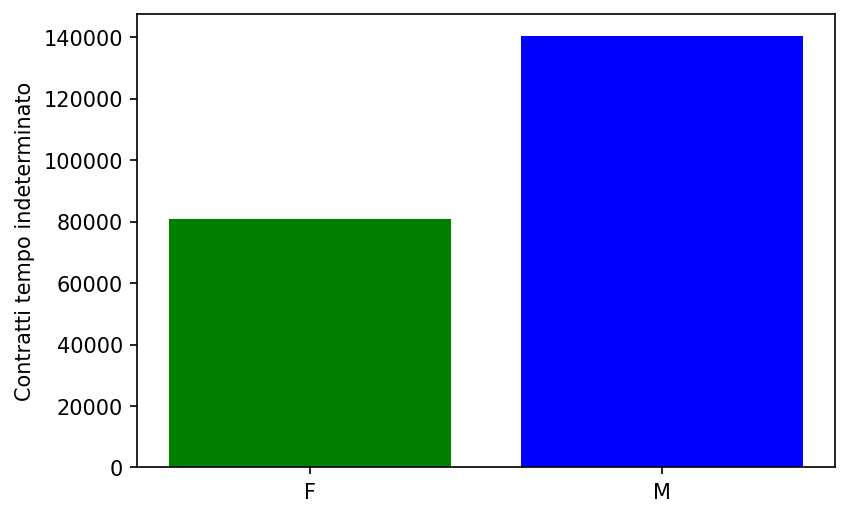

In [338]:
gender_df = rap_lavoro_attivati[['GENERE', "CONTRATTO"]]
gender_df = gender_df[gender_df['CONTRATTO'] == 'LAVORO A TEMPO INDETERMINATO']
group_gender = gender_df.groupby(['GENERE']).count()

fig, ax = plt.subplots()
colors = ['green', 'blue']
ax.bar(group_gender.index, group_gender['CONTRATTO'], color=colors)
ax.set_ylabel('Contratti tempo indeterminato')
#ax.get_xaxis().set_visible(False)
#plt.xticks(rotation=90)
plt.show()

In [339]:
set(rap_lavoro_attivati['CONTRATTO'])

{'APPRENDISTATO DI ALTA FORMAZIONE E RICERCA',
 'APPRENDISTATO PER LA QUALIFICA E PER IL DIPLOMA PROFESSIONALE, IL DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE E IL CERTIFICATO DI SPECIALIZZAZIONE TECNICA SUPERIORE',
 'APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO DI MESTIERE',
 'COLLABORAZIONE COORDINATA E CONTINUATIVA',
 'CONTRATTI DI BORSA LAVORO E ALTRE WORK EXPERIENCES',
 'CONTRATTO DI AGENZIA',
 'CONTRATTO DI FORMAZIONE LAVORO (SOLO PUBBLICA AMMINISTRAZIONE)',
 'LAVORO A DOMICILIO',
 'LAVORO A TEMPO DETERMINATO',
 'LAVORO A TEMPO DETERMINATO  PER SOSTITUZIONE',
 'LAVORO A TEMPO INDETERMINATO',
 'LAVORO AUTONOMO NELLO SPETTACOLO',
 'LAVORO CONGIUNTO IN AGRICOLTURA',
 'LAVORO DOMESTICO',
 'LAVORO DOMESTICO A TEMPO INDETERMINATO',
 'LAVORO INTERMITTENTE',
 'LAVORO O ATTIVITÀ SOCIALMENTE UTILE (LSU - ASU)',
 'LAVORO RIPARTITO',
 'TIROCINIO'}

### Dividing by age group
For a better reading of teh data we create a new column for the age group

In [340]:
bins = np.arange(14, 68, 3).tolist()
bins

[14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65]

In [341]:
bins = np.arange(14, 68, 3).tolist()
rap_lavoro_attivati['agerange'] = pd.cut(rap_lavoro_attivati['ETA'], bins)
rap_lavoro_attivati

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,agerange
6,2018,F,56,C,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,"(53, 56]"
12,2019,F,34,P,LAUREA - Vecchio o nuovo ordinamento,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,"(32, 35]"
23,2018,M,54,A,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE MISTO,BERGAMO,MAROCCO,"(53, 56]"
28,2019,F,45,T,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,"(44, 47]"
29,2019,F,28,G,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA,"(26, 29]"
...,...,...,...,...,...,...,...,...,...,...
9579758,2018,M,29,I,NESSUN TITOLO DI STUDIO,LAVORO INTERMITTENTE,NON DEFINITO,MONZA E BRIANZA,ITALIA,"(26, 29]"
9579764,2018,F,41,I,TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCO...,LAVORO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA,"(38, 41]"
9579777,2018,F,35,I,LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,MONZA E BRIANZA,ITALIA,"(32, 35]"
9579779,2018,M,35,F,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MONZA E BRIANZA,ITALIA,"(32, 35]"


In [342]:
rap_lavoro_attivati.dropna(axis = 0, inplace = True)

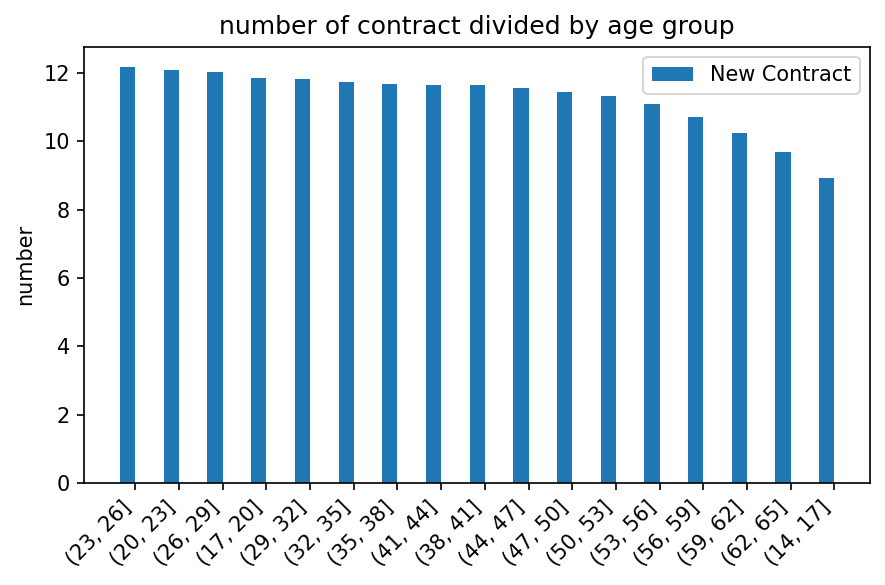

In [343]:
testAge = rap_lavoro_attivati.agerange.value_counts()

labels = testAge.index
newContract = np.log(testAge.values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, newContract, width, label='New Contract')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('number')
ax.set_title('number of contract divided by age group')
ax.set_xticks(x)
ax.set_xticklabels(labels=labels,rotation=45,
    horizontalalignment='right');
ax.legend()



fig.tight_layout()

plt.show()

## Introducing another dataset
This dataset contain the level of education for age referred to the region lombardy from the year 2018 to 2020.The educational level  are coded in teh following way:
- NED = nessun titolo di studio
- IL =  analfabeti
- LBNA = analfabeti privi di titolo di studio
- PSE = licenza di scuola elementare
- LSE = licenza media o avviamento professionale (conseguito non oltre l'anno 1965)/ Diploma di istruzione secondaria di I grado
- USE_IF = Diploma di istruzione secondaria di II grado o di qualifica professionale (corso di 3-4 anni) compresi IFTS
- BL = Diploma tecnico superiore ITS o titolo di studio terziario di primo livello
- ML_RDD = titolo di studio terziario di secondo livello e dottorato di ricerca
- ML = Titolo di studio terziario di secondo livello
- RDD = Dottorato di ricerca/diploma accademico di formazione alla ricerca
- ALL = totale

In [344]:
grado_istruzione_age  = pd.read_csv(PurePath('dataset', 'Grado_istruzione_per_età_Lombardia_IT1,DF_DCSS_ISTR_LAV_PEN_2_REG.csv'),low_memory=False)
grado_istruzione_age.head()

,DATAFLOW,FREQ,REF_AREA,INDICATOR,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE,OBS_STATUS,NOTE_DS,NOTE_REF_AREA,NOTE_INDICATOR,NOTE_GENDER,NOTE_AGE_NOCLASS,NOTE_CITIZENSHIP,NOTE_EDU_ATTAIN,NOTE_CUR_ACT_STAT,NOTE_LOC_DEST,NOTE_REAS_COMMUTING
0,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2018,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
1,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2019,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
2,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,ALL,2020,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,99_N1,NaN,NaN
3,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,BL,2018,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BL_N1,99_N1,NaN,NaN
4,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_91_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE65,BL,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BL_N1,99_N1,NaN,NaN


In [345]:
print([grado_istruzione_age.isnull().sum()])

[DATAFLOW                    0
FREQ                        0
REF_AREA                    0
INDICATOR                   0
GENDER                      0
AGE_NOCLASS                 0
EDU_ATTAIN                  0
TIME_PERIOD                 0
OBS_VALUE                   0
OBS_STATUS             508956
NOTE_DS                508956
NOTE_REF_AREA          504601
NOTE_INDICATOR         508956
NOTE_GENDER            508956
NOTE_AGE_NOCLASS       508956
NOTE_CITIZENSHIP       508956
NOTE_EDU_ATTAIN        185896
NOTE_CUR_ACT_STAT           0
NOTE_LOC_DEST          508956
NOTE_REAS_COMMUTING    508956
dtype: int64]


there are some column with null value that can be deleted

In [346]:
grado_istruzione_age = grado_istruzione_age[['REF_AREA', 'GENDER', 'AGE_NOCLASS', 'EDU_ATTAIN', 'TIME_PERIOD', 'OBS_VALUE']]

In [347]:
grado_istruzione_age ['AGE_NOCLASS'].value_counts()

Y_GE9     145979
Y25-49     92357
Y50-64     91652
Y_GE65     90061
Y9-24      88907
Name: AGE_NOCLASS, dtype: int64

those value represet age range in specific:
- Y_GE9: all people with age greater than 9, in this case all the people in the dataset
- Y25-49: people with an age between 25 and 49
- Y50-64: people with an age between 50 and 64
- Y_GE65: people with more than 65 years
- Y9-24: people with an age between 9 and 24

In the following part we will add a column with the saem age range of the dataset *Grado_istruzione_per_età_Lombardia*

because in the dataset *rapporti di lavoro* the minimum age is 16 while in *Grado_istruzione_per_età_Lombardia* is 9 we will delete all the illiterate and the people with only elementary school license with the age between 9 and 24  from the dataset, we have choose to do so because the majority of people in that age range with only elementary school license are the one under 16 year

In [348]:
grado_istruzione_age = grado_istruzione_age [~((grado_istruzione_age ['EDU_ATTAIN']== 'IL')|(grado_istruzione_age ['EDU_ATTAIN']== 'LBNA')|((grado_istruzione_age ['EDU_ATTAIN']== 'PSE')&(grado_istruzione_age ['AGE_NOCLASS']== 'Y9_24')))]
grado_istruzione_age

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
0,012001,F,Y_GE65,ALL,2018,54
1,012001,F,Y_GE65,ALL,2019,59
2,012001,F,Y_GE65,ALL,2020,63
3,012001,F,Y_GE65,BL,2018,3
4,012001,F,Y_GE65,BL,2019,3
...,...,...,...,...,...,...
508951,ITC4B,T,Y9-24,PSE,2019,12282
508952,ITC4B,T,Y9-24,PSE,2020,12409
508953,ITC4B,T,Y9-24,USE_IF,2018,16491
508954,ITC4B,T,Y9-24,USE_IF,2019,16647


In [349]:
print(rap_lavoro_attivati['TITOLOSTUDIO'].head())
grado_istruzione_age['EDU_ATTAIN'].head()

6                                         LICENZA MEDIA
12                 LAUREA - Vecchio o nuovo ordinamento
23                              NESSUN TITOLO DI STUDIO
28                              NESSUN TITOLO DI STUDIO
29    DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...
Name: TITOLOSTUDIO, dtype: string


0    ALL
1    ALL
2    ALL
3     BL
4     BL
Name: EDU_ATTAIN, dtype: object

The series `TITOLO_STUDIO` and `EDU_ATTAIN` don't match easily, but we can map the values of `EDU_ATTAIN` into `TITOLO_STUDIO`.

In [350]:
print(series_to_set('TITOLOSTUDIO', rap_lavoro_attivati))
print(series_to_set('EDU_ATTAIN', grado_istruzione_age))

{"DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA", 'NESSUN TITOLO DI STUDIO', "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()", 'TITOLO DI STUDIO POST-LAUREA', 'MASTER UNIVERSITARIO DI PRIMO LIVELLO', 'LICENZA ELEMENTARE', 'LICENZA MEDIA', 'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO', 'DIPLOMA UNIVERSITARIO', 'DIPLOMA DI SPECIALIZZAZIONE', 'TITOLO DI DOTTORE DI RICERCA', 'LAUREA - Vecchio o nuovo ordinamento'}
{'RDD', 'ML', 'LSE', 'ML_RDD', 'PSE', 'ALL', 'BL', 'NED', 'USE_IF'}


In [351]:
grado_istruzione_age.loc[(grado_istruzione_age.EDU_ATTAIN.isin(['ML_RDD'])) & ~(grado_istruzione_age.AGE_NOCLASS == 'Y_GE9')]

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
9,012001,F,Y_GE65,ML_RDD,2018,4
10,012001,F,Y_GE65,ML_RDD,2019,4
11,012001,F,Y_GE65,ML_RDD,2020,3
58,012001,F,Y25-49,ML_RDD,2018,16
59,012001,F,Y25-49,ML_RDD,2019,15
...,...,...,...,...,...,...
508924,ITC4B,T,Y50-64,ML_RDD,2019,7841
508925,ITC4B,T,Y50-64,ML_RDD,2020,8141
508944,ITC4B,T,Y9-24,ML_RDD,2018,302
508945,ITC4B,T,Y9-24,ML_RDD,2019,186


In [352]:
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age['TIME_PERIOD'] != 2020]
grado_istruzione_age = grado_istruzione_age[~grado_istruzione_age.EDU_ATTAIN.isin(['ALL', 'ML', 'RDD'])]
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.AGE_NOCLASS != 'Y_GE9']
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.GENDER != 'T']
grado_istruzione_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
3,012001,F,Y_GE65,BL,2018,3
4,012001,F,Y_GE65,BL,2019,3
6,012001,F,Y_GE65,LSE,2018,11
7,012001,F,Y_GE65,LSE,2019,19
9,012001,F,Y_GE65,ML_RDD,2018,4


In [353]:
edu_map = {
    'IL': 'NESSUN TITOLO DI STUDIO',
    'NED': 'NESSUN TITOLO DI STUDIO',
    'LBNA': 'NESSUN TITOLO DI STUDIO',
    'PSE': 'LICENZA ELEMENTARE',
    'LSE': 'LICENZA MEDIA',
    'USE_IF': 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()": 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA": 'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE',
    'BL': 'LAUREA',
    'ML_RDD': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'MASTER UNIVERSITARIO DI PRIMO LIVELLO': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'LAUREA - Vecchio o nuovo ordinamento': 'LAUREA',
    'DIPLOMA DI SPECIALIZZAZIONE': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'DIPLOMA UNIVERSITARIO': 'LAUREA',
    'TITOLO DI STUDIO POST-LAUREA': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO',
    'TITOLO DI DOTTORE DI RICERCA': 'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO'
}


In [354]:
def mapping(series, mapp): 
    series = series.apply(lambda x: mapp.get(x) if mapp.get(x) != None else x)
    return series

rap_lavoro_attivati['TITOLOSTUDIO'] = mapping(rap_lavoro_attivati['TITOLOSTUDIO'], edu_map)

grado_istruzione_age['EDU_ATTAIN'] = mapping(grado_istruzione_age['EDU_ATTAIN'], edu_map)

grado_istruzione_age['EDU_ATTAIN']


3                                                    LAUREA
4                                                    LAUREA
6                                             LICENZA MEDIA
7                                             LICENZA MEDIA
9         TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...
                                ...                        
508831                              NESSUN TITOLO DI STUDIO
508833                                   LICENZA ELEMENTARE
508834                                   LICENZA ELEMENTARE
508836           DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
508837           DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
Name: EDU_ATTAIN, Length: 135309, dtype: object

In [355]:
titoli = set(rap_lavoro_attivati['TITOLOSTUDIO'])

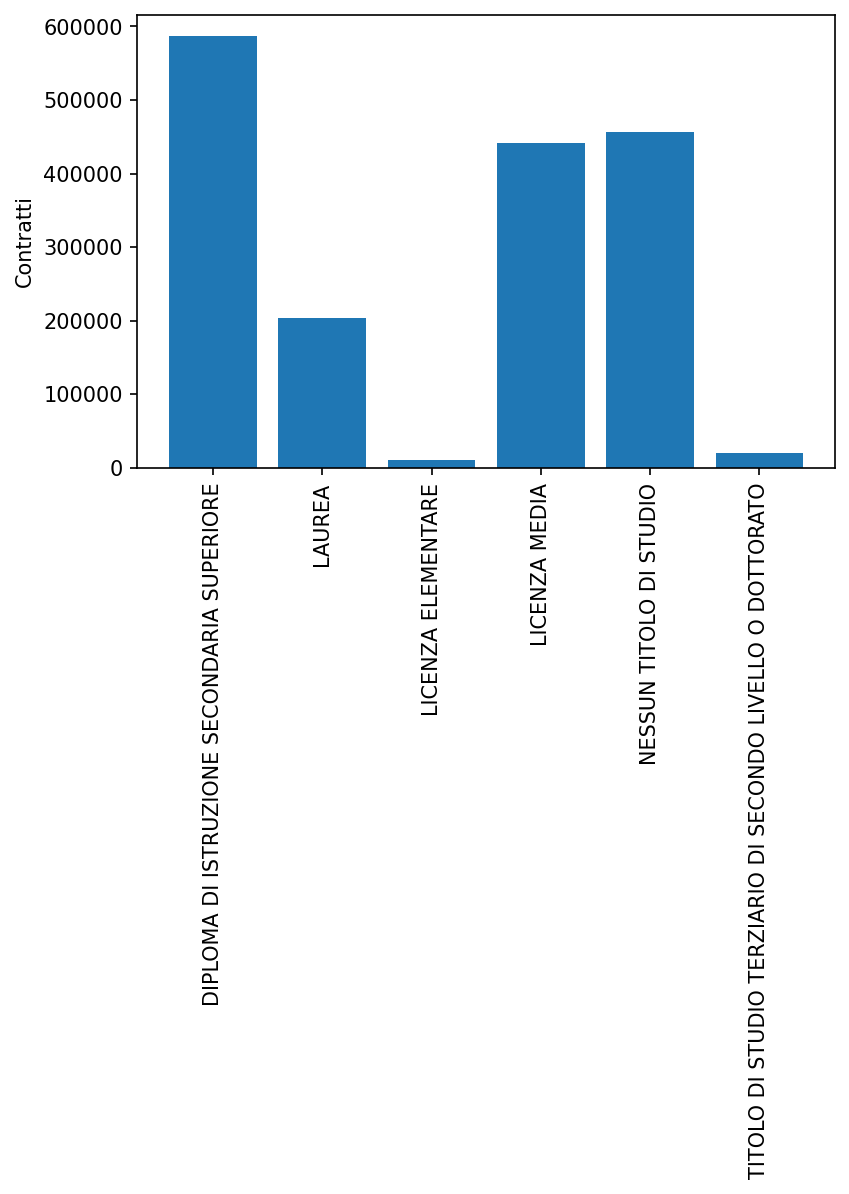

In [356]:
istruction_df = rap_lavoro_attivati[['TITOLOSTUDIO', "CONTRATTO"]]
istruction_df = istruction_df[(istruction_df['TITOLOSTUDIO'].isin(titoli))]
group_ist = istruction_df.groupby(['TITOLOSTUDIO']).count()
group_ist['CONTRATTO']
fig, ax = plt.subplots()
ax.bar(group_ist.index, group_ist['CONTRATTO'])
ax.set_ylabel('Contratti')
plt.xticks(rotation=90)
plt.show()

In [357]:
len(rap_lavoro_attivati)

1720158

In [358]:
test = group_ist
test['TITOLOSTUDIO'] = test.index
test.head()

,CONTRATTO,TITOLOSTUDIO
TITOLOSTUDIO,,
DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE,586395,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE
LAUREA,203123,LAUREA
LICENZA ELEMENTARE,11437,LICENZA ELEMENTARE
LICENZA MEDIA,441966,LICENZA MEDIA
NESSUN TITOLO DI STUDIO,457215,NESSUN TITOLO DI STUDIO


In [359]:
test_ist = grado_istruzione_age[grado_istruzione_age['EDU_ATTAIN'].isin(titoli)]
test['OBS_VALUE'] = test_ist.groupby(['EDU_ATTAIN']).sum()['OBS_VALUE']

In [360]:
test.loc[:, 'CONTRATTO'] = test['CONTRATTO']/test['OBS_VALUE']

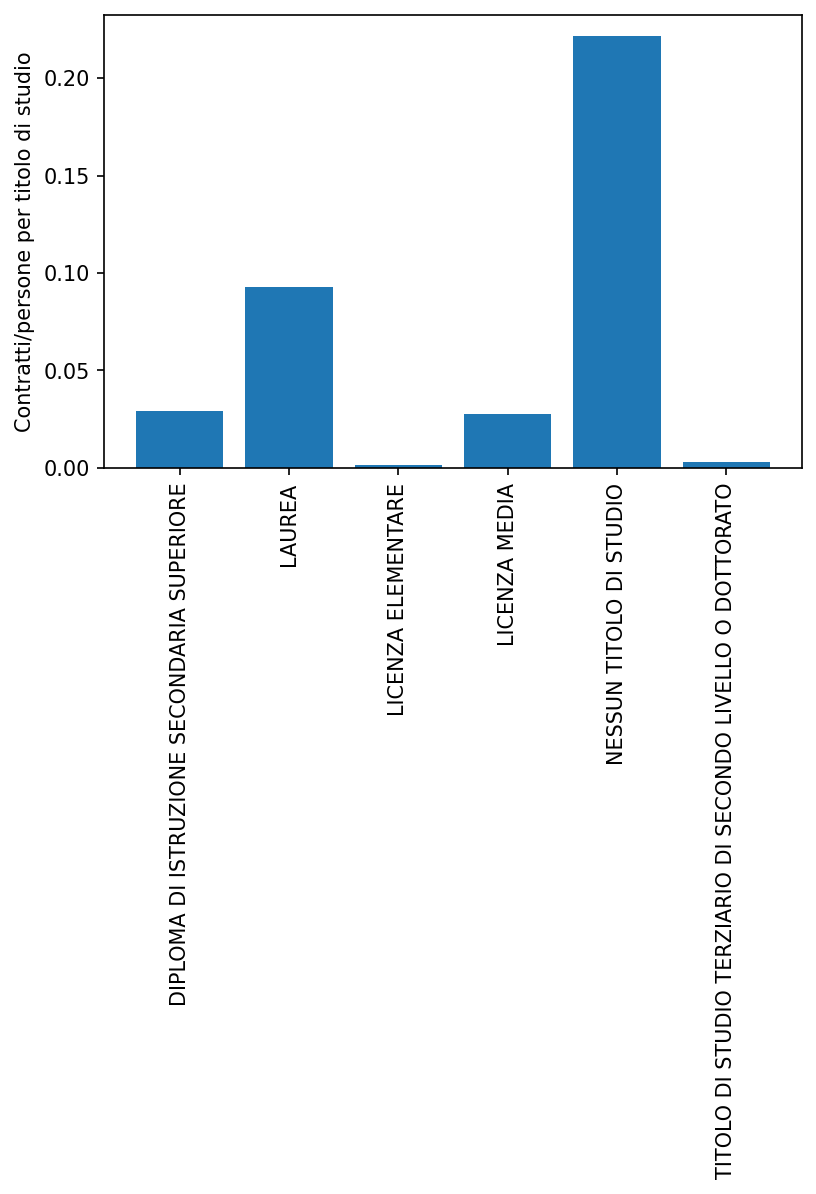

In [361]:
fig, ax = plt.subplots()
ax.bar(test.index, test['CONTRATTO'])
ax.set_ylabel('Contratti/persone per titolo di studio')
plt.xticks(rotation=90)
plt.show()

In [362]:
settori = set(rap_lavoro_attivati['SETTOREECONOMICODETTAGLIO'])
settori

{'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U'}

In [363]:
grado_istruzione_age['OBS_VALUE'].sum()

55507347

In [364]:
grado_istruzione_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
3,012001,F,Y_GE65,LAUREA,2018,3
4,012001,F,Y_GE65,LAUREA,2019,3
6,012001,F,Y_GE65,LICENZA MEDIA,2018,11
7,012001,F,Y_GE65,LICENZA MEDIA,2019,19
9,012001,F,Y_GE65,TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...,2018,4


In the next section we'll see a graph comparing the number of contract activated and the tota number of population in 2018

C:\Users\achil\AppData\Local\Temp/ipykernel_24196/4154598981.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activate2018['agerange'] = pd.cut(activate2018['ETA'], bins, labels = labels,include_lowest = True)
C:\Users\achil\AppData\Local\Temp/ipykernel_24196/4154598981.py:17: RuntimeWarning: divide by zero encountered in log
  newContract = np.log(testAge.values)


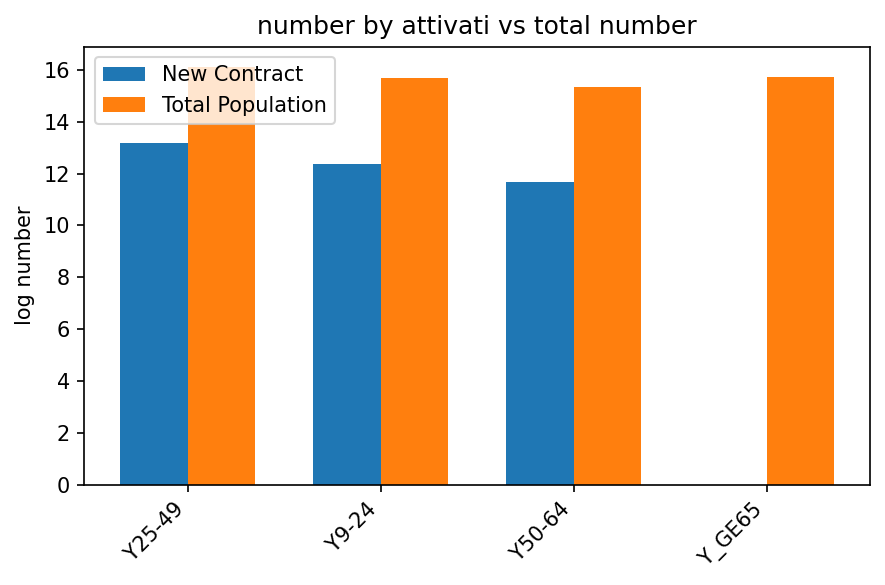

In [366]:
import datetime as dt

activate2018 = rap_lavoro_attivati[rap_lavoro_attivati['DATA'] == 2018]
bins = [0,25, 50, 65, 200]
labels = ['Y9-24', 'Y25-49', 'Y50-64','Y_GE65' ]
activate2018['agerange'] = pd.cut(activate2018['ETA'], bins, labels = labels,include_lowest = True)



istr2018 = grado_istruzione_age[(grado_istruzione_age['TIME_PERIOD']== 2018)]
total = istr2018.groupby(['AGE_NOCLASS']).sum()


testAge = activate2018['agerange'].value_counts()

labels = testAge.index
newContract = np.log(testAge.values)
totalPopulation = np.log(total['OBS_VALUE'].values)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, newContract, width, label='New Contract')
rects2 = ax.bar(x + width/2, totalPopulation, width, label='Total Population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('log number')
ax.set_title('number by attivati vs total number')
ax.set_xticks(x)
ax.set_xticklabels(labels=labels,rotation=45,
    horizontalalignment='right');
ax.legend()



fig.tight_layout()

plt.show()

In [367]:
city_codes = pd.read_excel(PurePath('dataset', 'Elenco-comuni-italiani.xls'))
city_codes = city_codes[['Codice Comune formato alfanumerico', 
                        'Denominazione in italiano',
                        'Denominazione Regione',
                        'Provincia',
                        'Codice NUTS3 2021',
                        'Codice NUTS2 2021 (3) '
                        ]]
city_codes = city_codes[city_codes['Denominazione Regione'] == 'Lombardia']
city_codes = city_codes.set_index('Codice Comune formato alfanumerico')
city_codes.loc[1] = ['','','Milano','ITC45','']   #The code in the dataset does not match with the code of Milano, 
                                                  #manually added
city_codes.head()

,Denominazione in italiano,Denominazione Regione,Provincia,Codice NUTS3 2021,Codice NUTS2 2021 (3)
Codice Comune formato alfanumerico,,,,,
12001,Agra,Lombardia,Varese,ITC41,ITC4
12002,Albizzate,Lombardia,Varese,ITC41,ITC4
12003,Angera,Lombardia,Varese,ITC41,ITC4
12004,Arcisate,Lombardia,Varese,ITC41,ITC4
12005,Arsago Seprio,Lombardia,Varese,ITC41,ITC4


In [368]:
def get_provincia_by_code(code):
    try:
        return city_codes[city_codes['Codice NUTS3 2021'] == code]['Provincia'].iloc[0]
    except: 
        if code == 'IT108':
            return 'MONZA E BRIANZA'
                    

In [369]:
area_codes = set(city_codes['Codice NUTS3 2021'])
area_codes.add('IT108')
grado_istruzione_age = grado_istruzione_age[grado_istruzione_age.REF_AREA.isin(area_codes)]

In [370]:
grado_istruzione_age['REF_AREA'] = grado_istruzione_age['REF_AREA'].apply(lambda x: get_provincia_by_code(x)) 
grado_istruzione_age

,REF_AREA,GENDER,AGE_NOCLASS,EDU_ATTAIN,TIME_PERIOD,OBS_VALUE
504396,MONZA E BRIANZA,F,Y_GE65,LAUREA,2018,610
504397,MONZA E BRIANZA,F,Y_GE65,LAUREA,2019,543
504399,MONZA E BRIANZA,F,Y_GE65,LICENZA MEDIA,2018,24744
504400,MONZA E BRIANZA,F,Y_GE65,LICENZA MEDIA,2019,25871
504402,MONZA E BRIANZA,F,Y_GE65,TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO ...,2018,3595
...,...,...,...,...,...,...
508831,Mantova,M,Y9-24,NESSUN TITOLO DI STUDIO,2019,4294
508833,Mantova,M,Y9-24,LICENZA ELEMENTARE,2018,6457
508834,Mantova,M,Y9-24,LICENZA ELEMENTARE,2019,6478
508836,Mantova,M,Y9-24,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE,2018,8556


In [371]:
grado_istruzione_age[grado_istruzione_age.REF_AREA == 'Milano'].groupby(['REF_AREA', 'TIME_PERIOD', 'GENDER', 'EDU_ATTAIN', 'AGE_NOCLASS']).sum().head()

OBS_VALUE
REF_AREA TIME_PERIOD GENDER EDU_ATTAIN                                 AGE_NOCLASS           
Milano   2018        F      DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE Y25-49          233709
                                                                       Y50-64          168626
                                                                       Y9-24            63168
                                                                       Y_GE65          104197
                            LAUREA                                     Y25-49           51061

In [372]:
series_to_set('REF_AREA', grado_istruzione_age)

{'Bergamo',
 'Brescia',
 'Como',
 'Cremona',
 'Lecco',
 'Lodi',
 'MONZA E BRIANZA',
 'Mantova',
 'Milano',
 'Pavia',
 'Sondrio',
 'Varese'}

In [373]:
condizione_professionale_age = pd.read_csv(PurePath('dataset', 'Condizione professionale per età - Lombardia.csv'),low_memory=False)
condizione_professionale_age.head()

,DATAFLOW,FREQ,REF_AREA,INDICATOR,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE,OBS_STATUS,NOTE_DS,NOTE_REF_AREA,NOTE_INDICATOR,NOTE_GENDER,NOTE_AGE_NOCLASS,NOTE_CITIZENSHIP,NOTE_EDU_ATTAIN,NOTE_CUR_ACT_STAT,NOTE_LOC_DEST,NOTE_REAS_COMMUTING
0,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,1,2018,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
1,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,1,2019,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
2,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,12,2018,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
3,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,12,2019,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN
4,IT1:DF_DCSS_ISTR_LAV_PEN_2_REG_93_ITC4(1.0),A,012001,RESPOP_AV,F,Y_GE15,22,2018,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALL_N1,NaN,NaN,NaN


In [374]:
condizione_professionale_age = condizione_professionale_age[['REF_AREA', 'GENDER', 'AGE_NOCLASS', 'CUR_ACT_STAT', 'TIME_PERIOD', 'OBS_VALUE']]
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
0,012001,F,Y_GE15,1,2018,42
1,012001,F,Y_GE15,1,2019,37
2,012001,F,Y_GE15,12,2018,7
3,012001,F,Y_GE15,12,2019,8
4,012001,F,Y_GE15,22,2018,49


In [375]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age.REF_AREA.isin(area_codes)]

condizione_professionale_age.loc[:, 'REF_AREA'] = condizione_professionale_age['REF_AREA'].apply(lambda x: get_provincia_by_code(x)) 
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388442,MONZA E BRIANZA,F,Y_GE15,1,2018,167236
388443,MONZA E BRIANZA,F,Y_GE15,1,2019,170506
388444,MONZA E BRIANZA,F,Y_GE15,12,2018,20274
388445,MONZA E BRIANZA,F,Y_GE15,12,2019,20119
388446,MONZA E BRIANZA,F,Y_GE15,22,2018,187510


Regarding the meaning of the values in `CUR_ACT_STAT`:
- $22$: labor force;
 - $1$ : employed;
 - $12$: unemployed;
- $23$: non-labor force.

Thus, for our analysis, we can keep the labor force only. 

In [376]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age['CUR_ACT_STAT'] == 22]
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388446,MONZA E BRIANZA,F,Y_GE15,22,2018,187510
388447,MONZA E BRIANZA,F,Y_GE15,22,2019,190625
388464,MONZA E BRIANZA,F,Y_GE65,22,2018,3750
388465,MONZA E BRIANZA,F,Y_GE65,22,2019,4229
388482,MONZA E BRIANZA,F,Y15-24,22,2018,10108


For now, we can consider only the overall number and not the age range.

In [377]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age['AGE_NOCLASS'] == 'Y_GE15']
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388446,MONZA E BRIANZA,F,Y_GE15,22,2018,187510
388447,MONZA E BRIANZA,F,Y_GE15,22,2019,190625
388538,MONZA E BRIANZA,M,Y_GE15,22,2018,234355
388539,MONZA E BRIANZA,M,Y_GE15,22,2019,235901
388629,MONZA E BRIANZA,T,Y_GE15,22,2018,421865


The same holds for the `GENDER`, we can consider the total number of people that could potentially work.

In [378]:
condizione_professionale_age = condizione_professionale_age[condizione_professionale_age['GENDER'] == 'T']
condizione_professionale_age.head()

,REF_AREA,GENDER,AGE_NOCLASS,CUR_ACT_STAT,TIME_PERIOD,OBS_VALUE
388629,MONZA E BRIANZA,T,Y_GE15,22,2018,421865
388630,MONZA E BRIANZA,T,Y_GE15,22,2019,426526
389181,Varese,T,Y_GE15,22,2018,411189
389182,Varese,T,Y_GE15,22,2019,411106
389457,Como,T,Y_GE15,22,2018,277484


In [379]:
set(condizione_professionale_age['REF_AREA'])

{'Bergamo',
 'Brescia',
 'Como',
 'Cremona',
 'Lecco',
 'Lodi',
 'MONZA E BRIANZA',
 'Mantova',
 'Milano',
 'Pavia',
 'Sondrio',
 'Varese'}

In [380]:
set(rap_lavoro_attivati['PROVINCIAIMPRESA'])

{'BERGAMO',
 'BRESCIA',
 'COMO',
 'CREMONA',
 'LECCO',
 'LODI',
 'MANTOVA',
 'MILANO',
 'MONZA E BRIANZA',
 'PAVIA',
 'SONDRIO',
 'VARESE'}

<a id='ml_model'></a>
# Building a machine learning model
In this section we will see three different machine learning algorithm and decide which is the best for our goal.
Before creating the traing and test set we must encode the data before feeding it to the algorithm, to do this we will use two approach: the first approach is a simple encoding so for every distinct value of a feature will be assigned a number, the second approach try to assign to each different value of a feature a numeric value with some meaning when possible.

In [381]:
import matplotlib as mtl
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<a id='feature_encoding'></a>
## Feature encoding

The first step is to create a new dataset in which we will apply all the needed changes. Here we will add new columns for every encoding we perform, so in the end this dataset will contain the original value plus the encoded one, this choice has been made to recognize the original value from its encoding.

In [382]:
model_dt= rap_lavoro_attivati[['GENERE', 'ETA', 'agerange', 'TITOLOSTUDIO', 'CONTRATTO', 'MODALITALAVORO','PROVINCIAIMPRESA','SETTOREECONOMICODETTAGLIO']].copy(deep=True)

<a id='simp_encoding'></a>
### Simple encoding
In this case we simply assign a numeric value to each unique value. We convert all field to float except `CONTRATTO` that i converted to int and its values start from zero, this is done to avoid using deprecated method.

In [383]:
model_dt['RANKGENERE'] = model_dt['GENERE'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKTITOLOSTUDIO'] = model_dt['TITOLOSTUDIO'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKMODALITALAVORO'] = model_dt['MODALITALAVORO'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKPROVINCIAIMPRESA'] = model_dt['PROVINCIAIMPRESA'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKagerange'] = model_dt['agerange'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKSETTOREECONOMICODETTAGLIO'] = model_dt['SETTOREECONOMICODETTAGLIO'].rank(method='dense', ascending=False).astype('float')
model_dt['RANKCONTRATTO'] = model_dt['CONTRATTO'].rank(method='dense', ascending=False).astype('int')
model_dt['RANKCONTRATTO'] = model_dt['RANKCONTRATTO'].sub(1)

<a id='elab_encoding'></a>
### Elaborate encoding
 For this encoding we will assign to the field `RANKPROVINCIAIMPRESA` the number of people that live in that area, for the field `RANKTITOLOSTUDIO` the minimum age necessary to acquire that title and for the fields `RANKSETTOREECONOMICODETTAGLIO` and `RANKMODALITALAVORO` we will substitute a value with its occurences.

#### Province column

For obtainig the number of people we will use the dataset `Grado_istruzione_per_età_Lombardia`, from this dataset we will extrapolate the population for every lombary province during 2019, create a map and apply it to `model_dt`.

In [384]:
to_zip = grado_istruzione_age[grado_istruzione_age['TIME_PERIOD'] == 2019].groupby(['REF_AREA']).sum().copy()
to_zip['prov']= to_zip.index
zipped = zip(to_zip['prov'].str.upper(), to_zip['OBS_VALUE'])
province_map = dict(zipped)
model_dt['MyENPROVINCIAIMPRESA'] = mapping(model_dt['PROVINCIAIMPRESA'], province_map)

#### Study title column
Here we manually create a dictionary that assign to a study title its minimum age, then apply it to the dataset

In [385]:
rank_edu_map = {
    'NESSUN TITOLO DI STUDIO':0,
    'LICENZA ELEMENTARE':11,
    'LICENZA MEDIA':14,
    'DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE':19,
    'LAUREA':22,
    'TITOLO DI STUDIO TERZIARIO DI SECONDO LIVELLO O DOTTORATO':24    
}


In [386]:
model_dt['MyENTITOLOSTUDIO'] = mapping(model_dt['TITOLOSTUDIO'], rank_edu_map)

####  Economic sector and work modality columns
For these two columns we simply count the ocurrence and substittue them to the correct value

In [387]:
model_dt['MyENMODALITALAVORO'] = mapping(model_dt['MODALITALAVORO'], dict(model_dt['MODALITALAVORO'].value_counts()))
model_dt['MyENSETTOREECONOMICODETTAGLIO'] =  mapping(model_dt['SETTOREECONOMICODETTAGLIO'], dict(model_dt['SETTOREECONOMICODETTAGLIO'].value_counts()))

The remaining columns will use the previous encoding because age group and gender do not need to preserve information.

<a id='models_trainig'></a>
# Trainig the models
In this section we divide our data into trainig and testig data through the apposite funcion and take a first look at the model performances.This work will be repeted for the two different encoding.

In [388]:
X = model_dt[['RANKGENERE', 'RANKTITOLOSTUDIO', 'RANKagerange', 'RANKPROVINCIAIMPRESA','RANKSETTOREECONOMICODETTAGLIO', 'RANKMODALITALAVORO']]
y = model_dt['RANKCONTRATTO']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

## Simple encoding

### Multi layer perceptron

In [389]:
mlpModel = MLPClassifier(random_state=1, max_iter=5, hidden_layer_sizes=(24,24))
mlpModel = mlpModel.fit(X_train, y_train)

#prediction and probability
mlp_pred = mlpModel.predict(X_test)
mlp_proba = mlpModel.predict_proba(X_test)

#Report metrix
reportMLP = classification_report(y_test, mlp_pred,output_dict= True)
accMlp = accuracy_score(y_test, mlp_pred)
print('Accuracy:')
print(accMlp)

C:\Users\achil\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\achil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:
0.7268091340340433


C:\Users\achil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\achil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random forest

In [390]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=24, max_depth=6, random_state=0)
model.fit(X_train, y_train)
    
print("Scoring...")

score = model.score(X_test, y_test)

print("Score: ", round(score*100, 3))

Scoring...
Score:  72.736


### XGboost

In [391]:
import xgboost as xgb

xg_reg = xgb.XGBClassifier(learning_rate = 0.3,
                max_depth =3, alpha = 2, n_estimators = 24, eval_metric='mlogloss',use_label_encoder =False)
#Fit the model
xg_reg.fit(X_train,y_train)
#xg_reg.save_model("categorical-model.json")

#Make predictions
preds = xg_reg.predict(X_test)

In [392]:
accuracy_score(y_test, preds)

0.7316389173100176

## Elaborate encoding

In [393]:
X = model_dt[['RANKGENERE', 'MyENTITOLOSTUDIO', 'RANKagerange', 'MyENPROVINCIAIMPRESA','MyENSETTOREECONOMICODETTAGLIO', 'MyENMODALITALAVORO']]
y = model_dt['RANKCONTRATTO']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [394]:
mlpModel = MLPClassifier(random_state=1, max_iter=5, hidden_layer_sizes=(24,24))
mlpModel = mlpModel.fit(X_train, y_train)

#prediction and probability
mlp_pred = mlpModel.predict(X_test)
mlp_proba = mlpModel.predict_proba(X_test)

#Report metrix
reportMLP = classification_report(y_test, mlp_pred,output_dict= True)
accMlp = accuracy_score(y_test, mlp_pred)
print('Accuracy:')
print(accMlp)

C:\Users\achil\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\achil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:
0.539094037763929


C:\Users\achil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\achil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [395]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=24, max_depth=6, random_state=0)
model.fit(X_train, y_train)
    
print("Scoring...")

# TODO: score your model on your test set

score = model.score(X_test, y_test)

print("Score: ", round(score*100, 3))

Scoring...
Score:  72.558


In [ ]:
import xgboost as xgb
xg_reg = xgb.XGBClassifier(learning_rate = 0.3,
                max_depth =3, alpha = 2, n_estimators = 24, eval_metric='mlogloss',use_label_encoder =False)
#Fit the model
xg_reg.fit(X_train,y_train)
#xg_reg.save_model("categorical-model.json")

#Make predictions
preds = xg_reg.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)